# New York Fare Classification

Download New York Fare dataset at Google Classroom

Objectives 
- learn embeddings
- learn dropout
- serve as another case study

Embedding
- a very powerful concept
- replaces label-encoding and one-hot encoding
  - label-encoding:  turns category into numbers
  - one-hot encodings: turns category into cols
- In neural network, we don't have to....
  - we instead assign a vector of numbers for each category
  - Let's say I have 1000 samples, one col with two categories (morning, afternoon)
    - SHAPE: (1000, 1)
  - But for neural network, we can first create random vectors representing each category
    - morning:   [1, 5, 0.3, 2, 5]
    - afternoon: [4, 3, 0.2, 1, 0.9]
    - SHAPE: (1000, 2, 5)

In [1]:
#import stuffs
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 1. ETL

In [2]:
df = pd.read_csv("../data/NYCTaxiFares.csv")

In [4]:
# df.head()
#1. convert UTC to New York time....
#2. extract hours, am/pm, day as features
#3. fare_class is our y/target/label
#4. engineer some distance features

In [6]:
#let's check class imbalance of data
#the first thing you must do in any dataset
df['fare_class'].value_counts(normalize=True)
#0 means less than 10 dollars
#1 means greater than equal to 10 dollars
#upsampling - SMOTE
#downsampling - I don't remember
#I think there is a library imblearn - take a look
#remember, if you use cross-validation, do it during cross-validation
#basically, no data leakage........

0    0.666667
1    0.333333
Name: fare_class, dtype: float64

## 2. EDA

We are lazy today....so skip....

## 3. Feature Engineering

- create the distance column for us

### Calculate the distance traveled
The <a href='https://en.wikipedia.org/wiki/Haversine_formula'>haversine formula</a> calculates the distance on a sphere between two sets of GPS coordinates.<br>
Here we assign latitude values with $\varphi$ (phi) and longitude with $\lambda$ (lambda).

The distance formula works out to

${\displaystyle d=2r\arcsin \left({\sqrt {\sin ^{2}\left({\frac {\varphi _{2}-\varphi _{1}}{2}}\right)+\cos(\varphi _{1})\:\cos(\varphi _{2})\:\sin ^{2}\left({\frac {\lambda _{2}-\lambda _{1}}{2}}\right)}}\right)}$

where

$\begin{align} r&: \textrm {radius of the sphere (Earth's radius averages 6371 km)}\\
\varphi_1, \varphi_2&: \textrm {latitudes of point 1 and point 2}\\
\lambda_1, \lambda_2&: \textrm {longitudes of point 1 and point 2}\end{align}$

In [8]:
def haversine_distance(df, lat1, long1, lat2, long2):
    """
    Calculates the haversine distance between 2 sets of GPS coordinates in df
    """
    r = 6371  # average radius of Earth in kilometers
       
    phi1 = np.radians(df[lat1])
    phi2 = np.radians(df[lat2])
    
    delta_phi    = np.radians(df[lat2]-df[lat1])
    delta_lambda = np.radians(df[long2]-df[long1])
     
    a = np.sin(delta_phi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = (r * c) # in kilometers

    return d

In [9]:
df.columns

Index(['pickup_datetime', 'fare_amount', 'fare_class', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count'],
      dtype='object')

In [10]:
#create a column called hav_dis inside df using this function
df['hav_dis'] = haversine_distance(df, 'pickup_latitude', 
                                       'pickup_longitude',
                                       'dropoff_latitude', 
                                       'dropoff_longitude',)

In [12]:
df['hav_dis'].describe()

count    120000.000000
mean          3.322160
std           3.337004
min           0.010208
25%           1.316428
50%           2.237084
75%           4.034564
max          28.846365
Name: hav_dis, dtype: float64

<AxesSubplot:xlabel='fare_class', ylabel='hav_dis'>

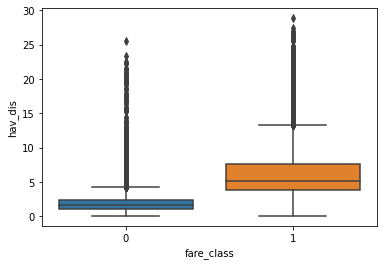

In [14]:
#a little bit
#bivariate analysis between hav_dis and fare_class
import seaborn as sns
sns.boxplot(x = df.fare_class, y = df.hav_dis)

## 4. Feature Extraction

1. convert UTC to New York time....
2. extract hours, am/pm, day as features

In [19]:
df['pickup_datetime'].iloc[0]

'2010-04-19 08:17:56 UTC'

In [28]:
#what is the time difference between UTC and New York....
df['new_york_time'] = pd.to_datetime(df['pickup_datetime'].str[:19]) - pd.Timedelta(hours=4)

In [33]:
#hour  - df['new_york_time'].dt.hour
#day   - df['new_york_time'].dt.strftime("%a")
#am/pm - np.where(hour < 12, 'am', 'pm')
#np.where(condition, if true, if false)
df['hour'] = df['new_york_time'].dt.hour
df['day']  = df['new_york_time'].dt.strftime("%a")
df['ampm'] = np.where(df['hour'] < 12, 'am', 'pm')

In [ ]:
#help me write a simple assert function
#there should be no more than 24 hours

#there should be no more than 7 days

#there should be only am and pm